# NYC Property Sales Prediction In Pandemic

In [1]:
import pandas as pd
import json
import folium
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats # for plot normal distribution
from scipy.stats import zscore # outlier
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")
#model
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import ensemble
# evaluation
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
# time series plot
from statsmodels.tsa.arima_model import ARIMA
# tree method important feature
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

# Introduction

By end of the project, I'll be able to tell:<br>
Property sales price inference: what contributes to a high price property in NYC? 
How the pandemic affects the NYC property sales price/ML model?

In [2]:
# import data & delete drop empty line & unuseful info
covid_data = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv')
manhattan = pd.read_csv('https://raw.githubusercontent.com/lijiaxingogo/HousePrice/master/manhattan.csv')
sp500 = pd.read_csv('https://raw.githubusercontent.com/lijiaxingogo/HousePrice/master/%5EGSPC%20(2).csv')
bronx = pd.read_csv('https://raw.githubusercontent.com/lijiaxingogo/HousePrice/master/bronx.csv')
queens = pd.read_csv('https://raw.githubusercontent.com/lijiaxingogo/HousePrice/master/queens.csv')
brooklyn = pd.read_csv('https://raw.githubusercontent.com/lijiaxingogo/HousePrice/master/brooklyn.csv')
statenisland = pd.read_csv('https://raw.githubusercontent.com/lijiaxingogo/HousePrice/master/statenisland.csv')
df = pd.concat([manhattan, bronx,queens, brooklyn, statenisland], ignore_index=True)
df.dropna(how='all',inplace=True)
df.dropna(how='all',axis=1,inplace=True)
del covid_data['DEATH_COUNT']
del covid_data['HOSPITALIZED_COUNT']
del df['APARTMENT NUMBER']
sp500 = sp500[['Date','Close','Open']]

In [3]:
# function for evaluating performance
def evaluation(name):
    print("R-squared of the model on the training set is: {}".format(name.score(x_train, y_train_log)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(name.score(x_test, y_test_log)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_log, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test_log, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test_log, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test_log - y_preds_test) / y_test_log)) * 100))
    print("-----covid 19 set statistics-----")
    print("R-squared of the model on the test set is: {}".format(name.score(x_covid19, y_covid19_log)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_covid19_log, y_preds_covid19)))
    print("Mean squared error of the prediction is: {}".format(mse(y_covid19_log, y_preds_covid19)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_covid19_log, y_preds_covid19)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_covid19_log - y_preds_covid19) / y_covid19_log)) * 100))
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df
# function for plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

# Data Preprocessing

In [4]:
# clean column name
new_columns = []
for each in df.columns:
    change = each.lower().strip().replace(' ', '_')
    new_columns.append(change)
df.columns = new_columns

### Data type transformation

In [5]:
# Check data type
# Numeric features: sale price/land square feet/gross square feet/total unit/year_built
# Category features: building class category/tax class at present/building_class_at_present/
category_data = df.select_dtypes('object')
for each in category_data.columns:
    print(each,df[each].nunique())

neighborhood 252
building_class_category 44
tax_class_at_present 10
building_class_at_present 160
address 75740
residential_units 230
total_units 252
land_square_feet 5905
gross_square_feet 5646
building_class_at_time_of_sale 162
sale_price 8727
sale_date 365


In [6]:
# residential_unit has '3' & 3 change them to numerical data first to unify format
df.loc[df['total_units']=='8,812','total_units'] = 1
df['total_units'] = pd.to_numeric(df['total_units'])
df.loc[df['residential_units']=='8,764','residential_units'] = 1
df['residential_units'] = pd.to_numeric(df['residential_units'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78333 entries, 0 to 83225
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   borough                         78333 non-null  float64
 1   neighborhood                    78333 non-null  object 
 2   building_class_category         78333 non-null  object 
 3   tax_class_at_present            78314 non-null  object 
 4   block                           78333 non-null  float64
 5   lot                             78333 non-null  float64
 6   building_class_at_present       78314 non-null  object 
 7   address                         78333 non-null  object 
 8   zip_code                        78324 non-null  float64
 9   residential_units               62445 non-null  float64
 10  commercial_units                62445 non-null  float64
 11  total_units                     62445 non-null  float64
 12  land_square_feet                

In [8]:
# transform numerical data type 
numerical_data = ['land_square_feet','gross_square_feet','sale_price']
for each in numerical_data:
    df[each] = df[each].str.replace(',','').astype(float) #ceerce for missing value
#df['total_units'] = df['total_units'].astype('float')
df['year_built'] = pd.to_numeric(df['year_built'])
df['residential_units'] = df['residential_units'].astype('float')

categorical_data = ['borough','tax_class_at_time_of_sale','building_class_category','tax_class_at_present','building_class_at_present','building_class_at_time_of_sale']
for each in categorical_data:
    df[each] = df[each].astype('category')
#


# unify date format
df['sale_date'] = pd.to_datetime(df['sale_date']).dt.strftime("%m/%d/%y")
covid_data['DATE_OF_INTEREST'] = pd.to_datetime(covid_data['DATE_OF_INTEREST']).dt.strftime("%m/%d/%y")
covid_data.rename(columns={'DATE_OF_INTEREST':'Date'},inplace=True)
sp500.Date = pd.to_datetime(sp500.Date).dt.strftime("%m/%d/%y")
df.rename(columns={'sale_date':'Date'},inplace=True)



### Merge Dataset

In [9]:
# merge sp500 data& covid19 data
df = df.merge(sp500, on = 'Date',how='left')
df = df.merge(covid_data, on='Date', how = 'left')
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78333 entries, 0 to 78332
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         78333 non-null  category      
 1   neighborhood                    78333 non-null  object        
 2   building_class_category         78333 non-null  category      
 3   tax_class_at_present            78314 non-null  category      
 4   block                           78333 non-null  float64       
 5   lot                             78333 non-null  float64       
 6   building_class_at_present       78314 non-null  category      
 7   address                         78333 non-null  object        
 8   zip_code                        78324 non-null  float64       
 9   residential_units               62445 non-null  float64       
 10  commercial_units                62445 non-null  float64       
 11  to

### duplicates

In [10]:
# drop duplicates
print(sum(df.duplicated()))
df.drop_duplicates(inplace=True)
print(sum(df.duplicated()))

56
0


### Missing value

,Missing Value%
Name,
zip_code,0.000115
tax_class_at_present,0.000243
building_class_at_present,0.000243
Close,0.020466
Open,0.020466
year_built,0.073713
residential_units,0.202703
commercial_units,0.202703
total_units,0.202703


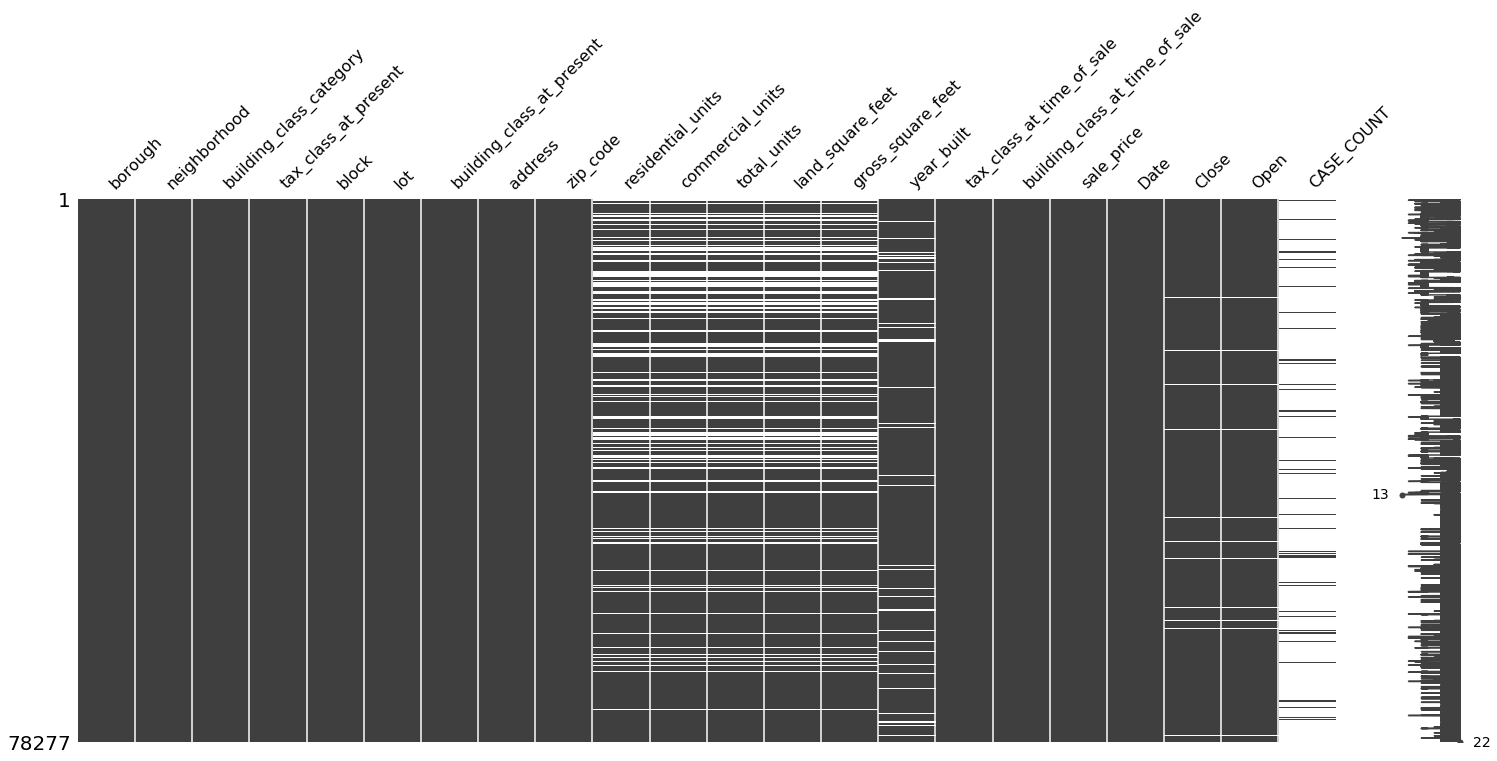

In [11]:
#check missing value after merge
missingno.matrix(df)
miss = df.isnull().sum()/len(df)
miss = miss[miss>0]
miss.sort_values(inplace=True)
miss = miss.to_frame()
miss.columns = ['Missing Value%']
miss.index.names = ['Name']
miss

In [12]:
# fill case_count nan value with 0
df['CASE_COUNT'].fillna(0,inplace = True)
# fill claose, land_square_feet, gross_square_feet with mean value
df['land_square_feet'].fillna(df['land_square_feet'].mean(),inplace = True)
df['gross_square_feet'].fillna(df['gross_square_feet'].mean(),inplace = True)
df['Close'].fillna(df['Close'].mean(),inplace = True)
df['Open'].fillna(df['Open'].mean(),inplace = True)
#fill zip_code with the highest frequency zip_code from the same borough
df.loc[(df['zip_code'].isnull())&(df['borough']==4),'zip_code'] = 11375
df.loc[(df['zip_code'].isnull()) & (df['borough']==5),'zip_code'] = 10314
# fill residential_units, commercial_unites and total_unit, year,tax_class_at_present with mode
missing_list = ['residential_units', 'commercial_units','total_units', 'year_built','tax_class_at_present','building_class_at_present']
for each in missing_list:
    mode = df[pd.notnull(df[each])][each].mode()[0]
    print('The mode is',mode, each)
    df[each] = df[each].fillna(mode) # mistakes: I'm replacing nan with another nah

The mode is 1.0 residential_units
The mode is 0.0 commercial_units
The mode is 1.0 total_units
The mode is 1920.0 year_built
The mode is 1 tax_class_at_present
The mode is D4 building_class_at_present


### Outlier

In [13]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price,Close,Open,CASE_COUNT
count,78277.000000,78277.000000,78277.000000,78277.000000,78277.000000,78277.000000,7.827700e+04,7.827700e+04,78277.000000,7.827700e+04,78277.000000,78277.000000,78277.000000
mean,4381.911162,364.466088,10854.939804,1.948146,0.318178,2.265710,7.022546e+03,4.298413e+03,1948.372855,1.492586e+06,3007.377935,3008.015152,213.860879
std,3658.730292,657.857223,561.632718,8.859019,6.722758,11.161684,1.494771e+05,4.882735e+04,34.407815,1.372391e+07,185.493413,183.922324,926.113348
min,1.000000,1.000000,10001.000000,0.000000,-16.000000,0.000000,0.000000e+00,0.000000e+00,1800.000000,0.000000e+00,2237.399902,2290.709961,0.000000
25%,1346.000000,22.000000,10306.000000,1.000000,0.000000,1.000000,1.440000e+03,0.000000e+00,1920.000000,0.000000e+00,2900.510010,2907.070068,0.000000
50%,3515.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.500000e+03,1.880000e+03,1940.000000,4.789690e+05,2991.780029,2994.010010,0.000000
75%,6507.000000,400.000000,11357.000000,2.000000,0.000000,2.000000,6.000000e+03,4.298413e+03,1965.000000,8.910000e+05,3120.459961,3119.209961,0.000000
max,16350.000000,9116.000000,11697.000000,826.000000,842.000000,842.000000,1.985040e+07,8.942176e+06,2019.000000,2.155000e+09,3386.149902,3380.449951,6374.000000


In [14]:
imp_num= ['land_square_feet','gross_square_feet','sale_price','year_built']
for each in imp_num:
    z_scores = zscore(df[each])
    print('-------{}-------'.format(each))
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

-------land_square_feet-------
The score threshold is: 1
Number of outliers is: 92
The score threshold is: 2
Number of outliers is: 63
The score threshold is: 3
Number of outliers is: 56
The score threshold is: 4
Number of outliers is: 52
-------gross_square_feet-------
The score threshold is: 1
Number of outliers is: 540
The score threshold is: 2
Number of outliers is: 295
The score threshold is: 3
Number of outliers is: 200
The score threshold is: 4
Number of outliers is: 167
-------sale_price-------
The score threshold is: 1
Number of outliers is: 817
The score threshold is: 2
Number of outliers is: 490
The score threshold is: 3
Number of outliers is: 336
The score threshold is: 4
Number of outliers is: 284
-------year_built-------
The score threshold is: 1
Number of outliers is: 15646
The score threshold is: 2
Number of outliers is: 1438
The score threshold is: 3
Number of outliers is: 0
The score threshold is: 4
Number of outliers is: 0


In [15]:
#drop off the data that not fall into a 25%-75% house price and with gross square feet more than 100000
df1= df[((df['sale_price'].isin(range(500000,12000000))))&(df['gross_square_feet'].isin(range(1,100000)))]
#|(df['land_square_feet'].isin([0]))
df1.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price,Close,Open,CASE_COUNT
count,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,1.932700e+04,19327.000000,19327.000000,19327.000000
mean,5561.359342,60.971542,11039.226005,2.121022,0.160035,2.281058,3390.412014,2762.926372,1941.210741,1.241421e+06,3006.245637,3006.900539,257.684379
std,3617.209059,140.761122,451.800387,3.655265,1.138045,3.833809,4000.761059,4202.423577,30.792453,1.402568e+06,193.600179,191.303710,1017.106961
min,10.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,400.000000,1.000000,1800.000000,5.000000e+05,2237.399902,2290.709961,0.000000
25%,2846.000000,19.000000,10468.000000,1.000000,0.000000,1.000000,2000.000000,1464.000000,1920.000000,6.400000e+05,2900.510010,2908.889893,0.000000
50%,5091.000000,38.000000,11225.000000,2.000000,0.000000,2.000000,2500.000000,2000.000000,1931.000000,8.200000e+05,2989.689941,2989.679932,0.000000
75%,7774.000000,63.000000,11373.000000,2.000000,0.000000,2.000000,4000.000000,2760.000000,1960.000000,1.185000e+06,3128.209961,3134.620117,0.000000
max,16323.000000,9040.000000,11694.000000,89.000000,65.000000,89.000000,271835.000000,88378.000000,2019.000000,1.195000e+07,3386.149902,3380.449951,6374.000000


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19327 entries, 0 to 78330
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         19327 non-null  category      
 1   neighborhood                    19327 non-null  object        
 2   building_class_category         19327 non-null  category      
 3   tax_class_at_present            19327 non-null  category      
 4   block                           19327 non-null  float64       
 5   lot                             19327 non-null  float64       
 6   building_class_at_present       19327 non-null  category      
 7   address                         19327 non-null  object        
 8   zip_code                        19327 non-null  float64       
 9   residential_units               19327 non-null  float64       
 10  commercial_units                19327 non-null  float64       
 11  to

# Data Exploration

### Target Vairable

In [17]:
df1['sale_price'].describe()

count    1.932700e+04
mean     1.241421e+06
std      1.402568e+06
min      5.000000e+05
25%      6.400000e+05
50%      8.200000e+05
75%      1.185000e+06
max      1.195000e+07
Name: sale_price, dtype: float64

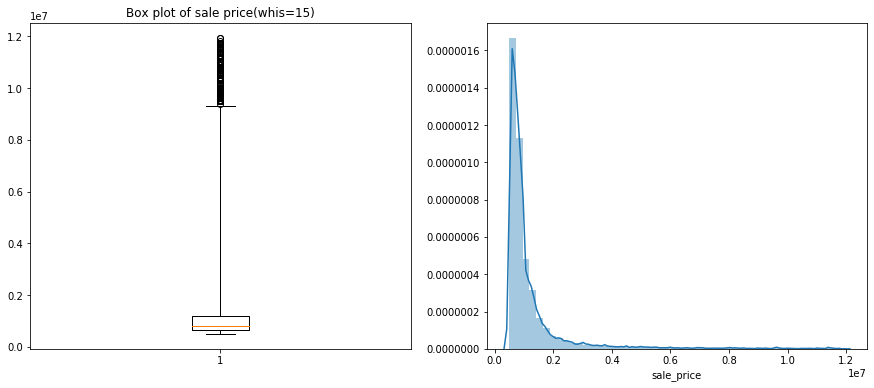

In [18]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.boxplot(df1['sale_price'],whis=15)
plt.title('Box plot of sale price(whis=15)')
plt.subplot(1,2,2)
sns.distplot(df1['sale_price'])
plt.show()

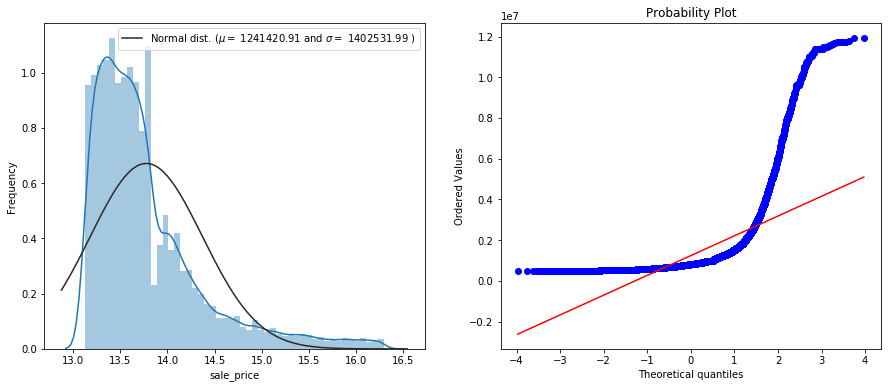

In [19]:
# after log transformation
# normalize: monotonic transformations(don't change relative order)
plt.subplots(figsize=(15,6))
plt.subplot(1,2,1)
norm_price = np.log1p(df1['sale_price'])
sns.distplot(norm_price, fit = stats.norm)
plt.ylabel('Frequency')
(mu, sigma) = stats.norm.fit(df1['sale_price'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
# You can't set the legend without sns.plot first

#probability plot
plt.subplot(1,2,2) # create new plot
stats.probplot(df1['sale_price'],plot=plt)
plt.show()

### Correlation

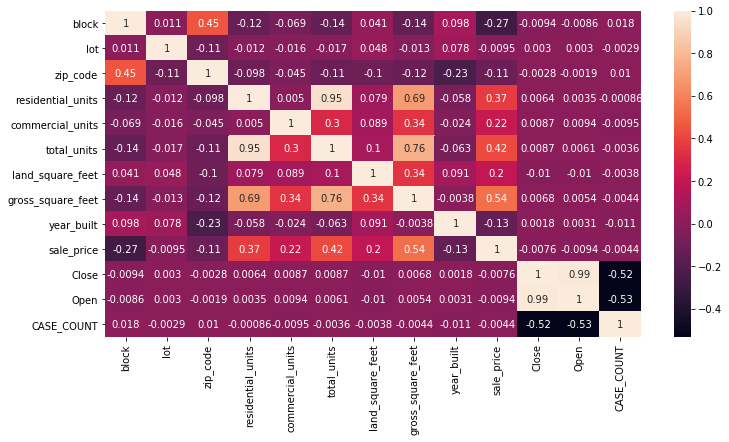

In [20]:
corr = df1.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)

### Building class

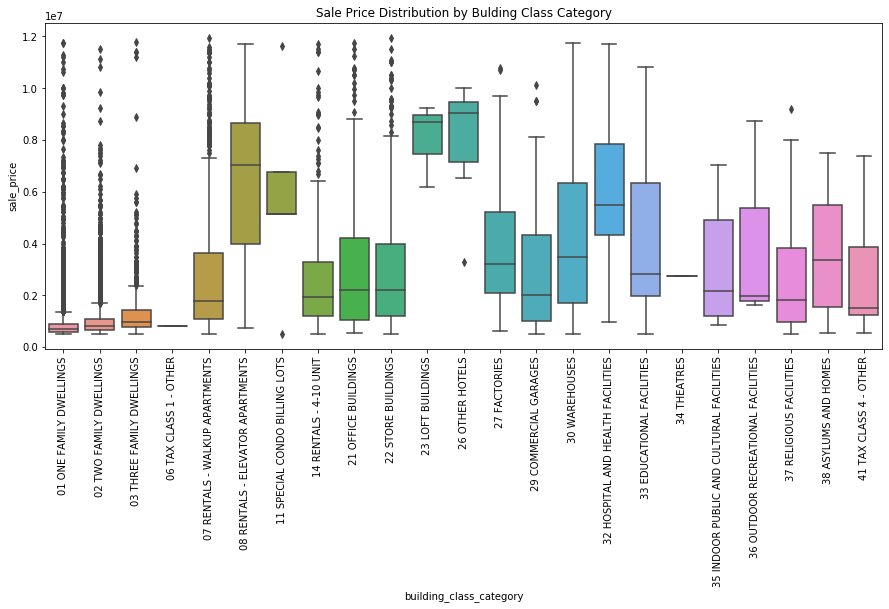

In [21]:
plt.figure(figsize=(15,6))
order = sorted(df1['building_class_category'].unique())
sns.boxplot(x='building_class_category', y='sale_price', data=df1, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Bulding Class Category')
plt.show()

### Tax class

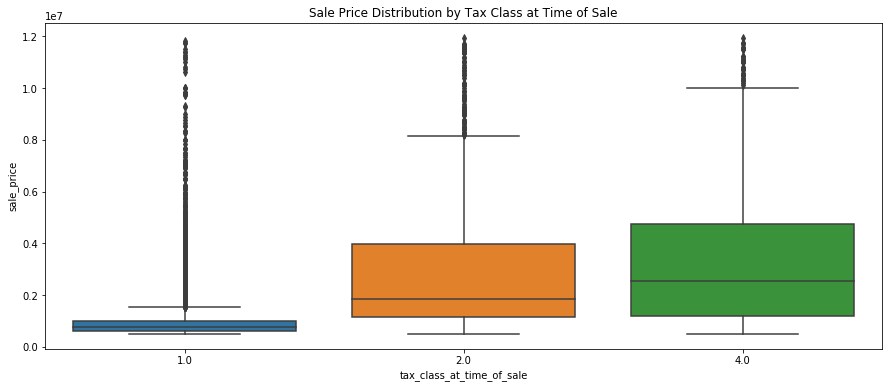

In [22]:
plt.figure(figsize=(15,6))
sns.boxplot(x='tax_class_at_time_of_sale',y='sale_price',data = df1)
plt.title('Sale Price Distribution by Tax Class at Time of Sale')
plt.show()

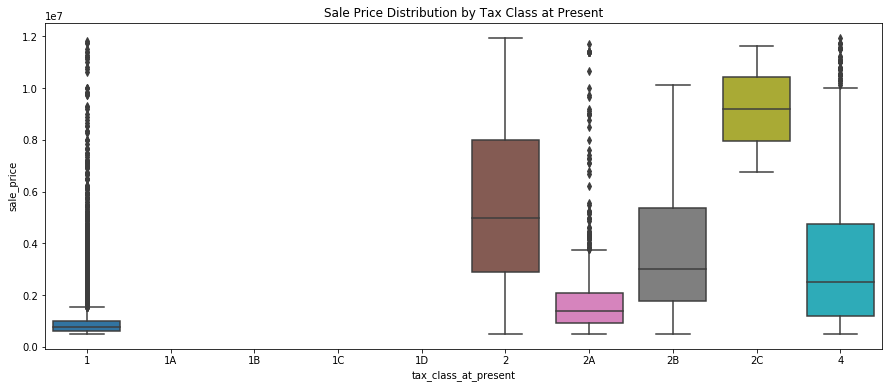

In [23]:
plt.figure(figsize=(15,6))
sns.boxplot(x='tax_class_at_present',y='sale_price',data = df1)
plt.title('Sale Price Distribution by Tax Class at Present')
plt.show()

### Date

In [24]:
count = df1[['Date','sale_price']].groupby('Date').count().reset_index()
sale_total = df1[['Date','sale_price']].groupby('Date').sum().reset_index()
sale_avg = df1[['Date','sale_price']].groupby('Date').mean().reset_index()

summary_date = count.merge(sale_total, on='Date',how='left')
summary_date = summary_date.merge(sale_avg, on='Date', how = 'left')

col_name = ['date','sale_number','sale_total','sale_avg']
summary_date.columns = col_name
summary_date['date'] = pd.to_datetime(summary_date['date'])

In [25]:
summary_date

,date,sale_number,sale_total,sale_avg
0,2019-05-01,79,114938425.0,1.454917e+06
1,2019-05-02,59,75882012.0,1.286136e+06
2,2019-05-03,67,66769263.0,9.965562e+05
3,2019-05-06,62,73579260.0,1.186762e+06
4,2019-05-07,84,107526084.0,1.280072e+06
...,...,...,...,...
283,2020-04-25,1,670000.0,6.700000e+05
284,2020-04-27,35,43018764.0,1.229108e+06
285,2020-04-28,28,38442499.0,1.372946e+06
286,2020-04-29,28,45299500.0,1.617839e+06


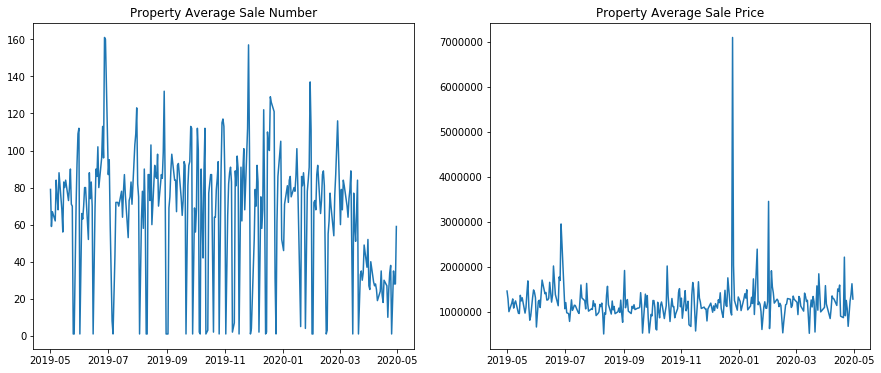

In [26]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(summary_date['date'],summary_date['sale_number'])
plt.title('Property Average Sale Number')
plt.subplot(1,2,2)
plt.plot(summary_date['date'],summary_date['sale_avg'])
plt.title('Property Average Sale Price')
plt.show()

### Location

In [27]:
zipcodes = df1.copy()
zipcodes['ZIP'] = zipcodes['zip_code'].astype(int).astype(str) #geojson file zipcodes are read as str

In [28]:
#find the borough number with zipcode
boroughs = zipcodes[['ZIP','borough']]
boroughs.drop_duplicates('ZIP', inplace=True)

In [29]:
#merge lat/lng with zipcode
uszip = pd.read_csv('USA_ZIP_LNG&LAT.txt', delimiter = ',',dtype=str)
zipcodes_agg = pd.merge(zipcodes.groupby('ZIP').agg(np.mean),uszip,how = 'left',on = 'ZIP')
#zipcodes_agg.drop(['borough'],axis=1,inplace=True)
zipcodes_agg = pd.merge(zipcodes_agg, boroughs, how='left',on='ZIP')
#find the missing value in the merged geodata
print(zipcodes_agg[zipcodes_agg['LAT'].isnull()]) ##row 129 zip 11249
# manually fill with zipcode
zipcodes_agg.loc[121,'LAT'] = 40.645
zipcodes_agg.loc[121,'LNG'] = -73.945

       ZIP      block       lot  zip_code  residential_units  \
121  11249  2332.3125  30.28125   11249.0             2.5625   

     commercial_units  total_units  land_square_feet  gross_square_feet  \
121           0.53125      3.09375        1874.78125         3648.34375   

     year_built   sale_price        Close         Open  CASE_COUNT  LAT  LNG  \
121  1919.90625  4447346.875  3045.588097  3045.587181      4.8125  NaN  NaN   

    borough  
121     3.0  


In [30]:
zipcodes_agg.loc[zipcodes_agg['borough'] == 1,'Borough']= 'Manhattan'
zipcodes_agg.loc[zipcodes_agg['borough'] == 2,'Borough']= 'Bronx'
zipcodes_agg.loc[zipcodes_agg['borough'] == 3,'Borough']= 'Brooklyn'
zipcodes_agg.loc[zipcodes_agg['borough'] == 4,'Borough']= 'Queens'
zipcodes_agg.loc[zipcodes_agg['borough'] == 5,'Borough']= 'Statenisland'
zipcodes_agg['LAT'].isnull().sum()

0

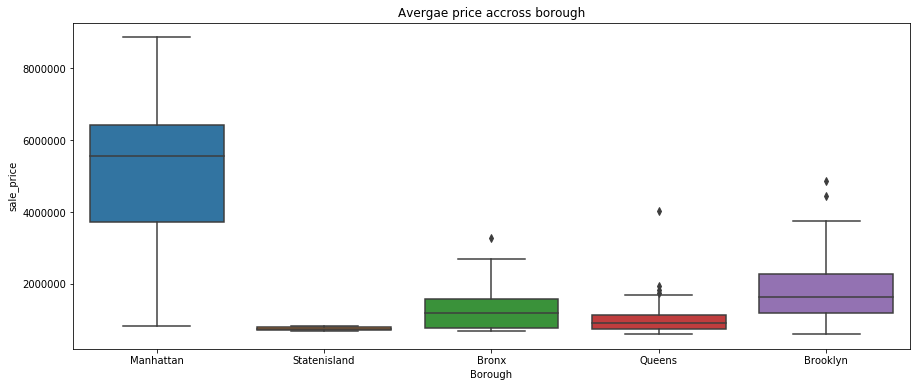

In [31]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Borough',y='sale_price',data = zipcodes_agg)
plt.title('Avergae price accross borough')
plt.show()

In [32]:
from folium.plugins import MarkerCluster # for clustering the markers
map = folium.Map(location=[40.750633, -73.997177], default_zoom_start=12)
map.choropleth(geo_data="nyc-zip-code.geojson", # I found this NYC zipcode boundaries by googling 
             data=zipcodes_agg, # my dataset
             columns=['ZIP', 'sale_price'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
             legend_name='SALE PRICE')

marker_cluster = MarkerCluster().add_to(map) # create marker clusters

for i in range(zipcodes_agg.shape[0]):
    location = [zipcodes_agg['LAT'][i],zipcodes_agg['LNG'][i]]
    tooltip = "Zipcode:{}<br> Borough: {}<br> Click for more".format(zipcodes_agg["ZIP"][i], zipcodes_agg['Borough'][i])
    
    folium.Marker(location, # adding more details to the popup screen using HTML
                  popup="""
                  <i>Mean sales price: </i> <br> <b>${}</b> <br> 
                  <i>mean commercial units: </i><b><br>{}</b><br>
                  <i>mean square feet: </i><b><br>{}</b><br>""".format(
                    round(zipcodes_agg['sale_price'][i],2), 
                    round(zipcodes_agg['commercial_units'][i],2), 
                    round(zipcodes_agg['gross_square_feet'][i],2)), 
                  tooltip=tooltip).add_to(marker_cluster)
map


### Residential units

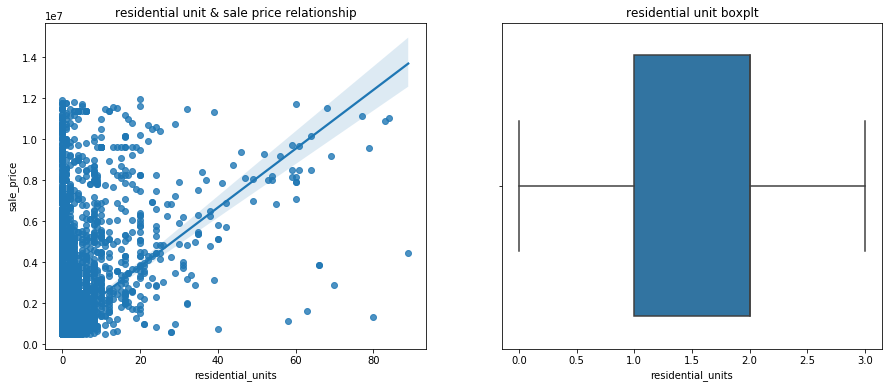

In [33]:
# residential_units
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='residential_units', y='sale_price',data=df1)
plt.title('residential unit & sale price relationship')
plt.subplot(1,2,2)
sns.boxplot(x='residential_units', data=df1,showfliers=False)
plt.title('residential unit boxplt')
plt.show()

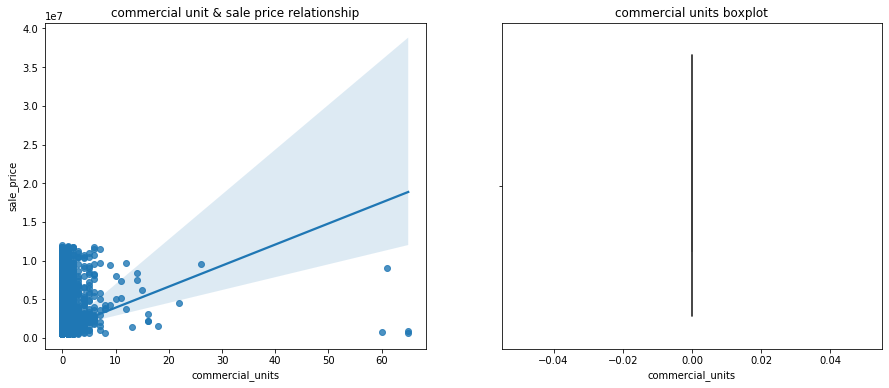

In [34]:
# commercial unit
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='commercial_units', y='sale_price',data=df1)
plt.title('commercial unit & sale price relationship')
plt.subplot(1,2,2)
sns.boxplot(x='commercial_units', data=df1,showfliers=False)
plt.title('commercial units boxplot')
plt.show()

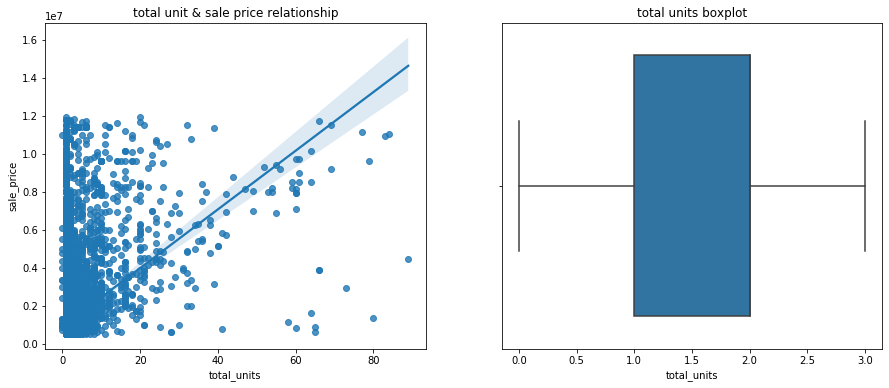

In [35]:
#total unit

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='total_units', y='sale_price',data=df1)
plt.title('total unit & sale price relationship')
plt.subplot(1,2,2)
sns.boxplot(x='total_units', data=df1,showfliers=False)
plt.title('total units boxplot')
plt.show()

### Sp500

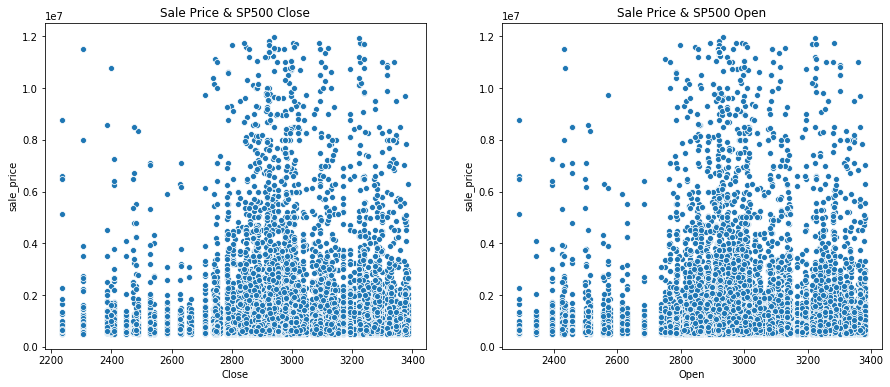

In [36]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.scatterplot(x='Close',y='sale_price',data=df1)
plt.title('Sale Price & SP500 Close')
plt.subplot(1,2,2)
sns.scatterplot(x='Open', y='sale_price', data=df1)
plt.title('Sale Price & SP500 Open')
plt.show()

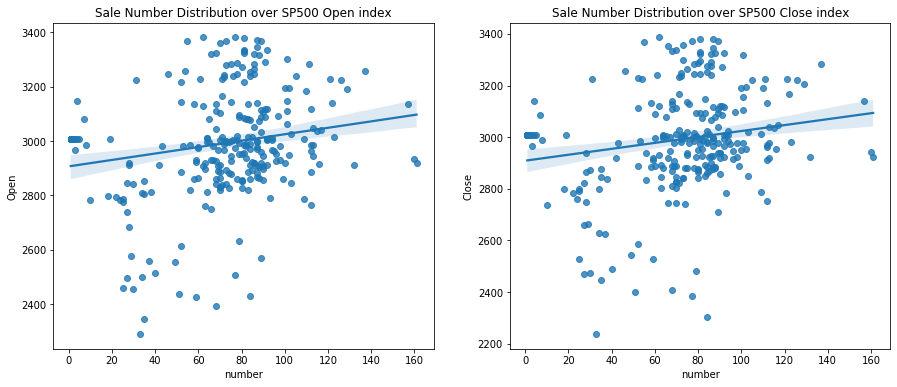

In [37]:
sp500_price = df1[['Close','Open','sale_price','Date']].groupby('Date').mean().reset_index()
sp500_price = pd.merge(sp500_price,df1[['sale_price','Date']].groupby('Date').count().reset_index(),on='Date',how='left')
sp500_price.rename(columns={'sale_price_x':'avg_sales','sale_price_y':'number'},inplace=True)
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.regplot(x = 'number',y='Open',data = sp500_price)
plt.title('Sale Number Distribution over SP500 Open index')
plt.subplot(1,2,2)
sns.regplot(x = 'number',y='Close',data = sp500_price)

plt.title('Sale Number Distribution over SP500 Close index')
plt.show()

### gross square feet

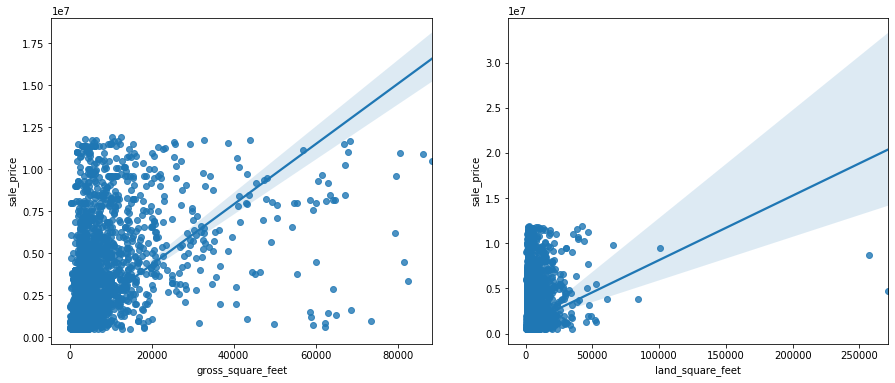

In [38]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='gross_square_feet', y='sale_price',data=df1)
plt.subplot(1,2,2)
sns.regplot(x='land_square_feet', y='sale_price',data=df1)
plt.show()#regplot:regresion line

# Feature engineering

!!!!一定要在分data/处理数据 之前把所有的features都安排好，包括one_hot_encoded

In [39]:
df1.loc[df1['commercial_units']>10,'units_category'] = 'A' ## commericial >10 
df1.loc[(df1['commercial_units']>0)&(df1['commercial_units']<=10),'units_category'] = 'B'  ## 0<commercial<=10 1
df1.loc[(df1['commercial_units']==0)&(df1['residential_units']==1),'units_category'] = 'C' ## commercial = 0 residential = 1
df1.loc[(df1['commercial_units']==0)&(df1['residential_units']>1)&(df1['residential_units']<10),'units_category'] = 'D' ## commercial =0 1<residential<10
df1.loc[(df1['commercial_units']==0)&(df1['residential_units']>=10),'units_category'] = 'E'## commercial = 0 residential>=10
df1.loc[(df1['commercial_units']==0)&(df1['residential_units']==0),'units_category'] = 'F'
df1['units_category'] = df1['units_category'].astype('category')

Text(0.5, 1.0, 'Unit category & Sale Price')

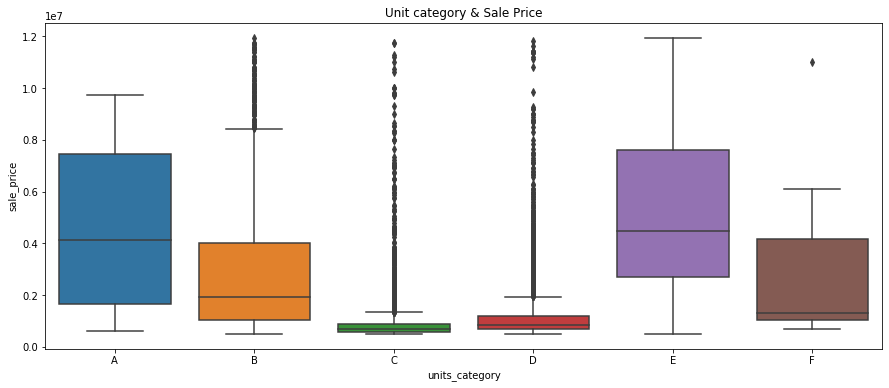

In [40]:
# visualize new feature: unit_category
plt.figure(figsize=(15,6))
sns.boxplot(x='units_category', y='sale_price',data=df1)
plt.title('Unit category & Sale Price')

In [41]:
df1.loc[df1['Open']>2700,'sp500_category'] = 0
df1.loc[df1['Open']<=2700,'sp500_category'] = 1
df1['sp500_category'] = df1['sp500_category'].astype('category')


Text(0.5, 1.0, 'sp500 category & Sale Price')

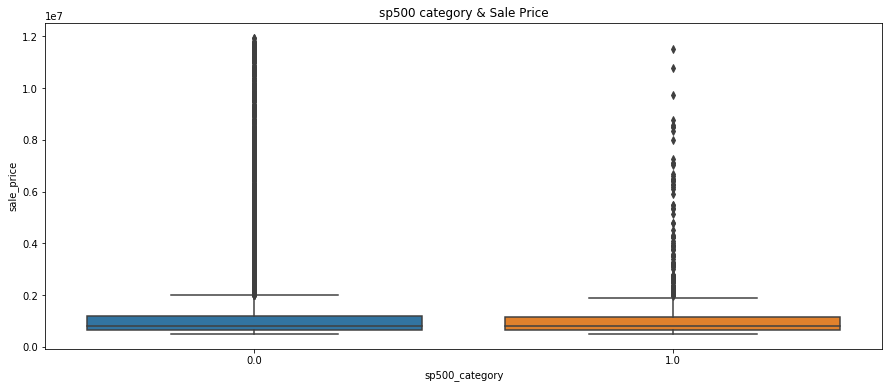

In [42]:
# visualize new feature: sp500 category
plt.figure(figsize=(15,6))
sns.boxplot(x='sp500_category', y='sale_price',data=df1)
plt.title('sp500 category & Sale Price')

In [43]:
# one hot encoding
one_hot_features = ['borough', 'building_class_category','tax_class_at_present','tax_class_at_time_of_sale','sp500_category','units_category']
one_hot_encoded = pd.get_dummies(df1[one_hot_features])
df1 = pd.concat([df1,one_hot_encoded],axis=1)

In [44]:
one_hot_encoded.head()

,borough_1.0,borough_2.0,borough_3.0,borough_4.0,borough_5.0,building_class_category_01 ONE FAMILY DWELLINGS,building_class_category_02 TWO FAMILY DWELLINGS,building_class_category_03 THREE FAMILY DWELLINGS,building_class_category_04 TAX CLASS 1 CONDOS,building_class_category_05 TAX CLASS 1 VACANT LAND,...,tax_class_at_time_of_sale_2.0,tax_class_at_time_of_sale_4.0,sp500_category_0.0,sp500_category_1.0,units_category_A,units_category_B,units_category_C,units_category_D,units_category_E,units_category_F
0,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
7,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
12,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [45]:

data_linear = df1.copy()
imp_num= ['land_square_feet','gross_square_feet','sale_price']
# lop transform the skew data
num_features = ['land_square_feet', 'gross_square_feet', 'year_built']
from scipy.stats import skew
skewed = data_linear[num_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data_linear[skewed] = np.log1p(data_linear[skewed])
#standardize x
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(data_linear[num_features]) # []: a column; [][][]rows
for i, col in enumerate(num_features):
    data_linear[col] = X[:,i]

In [46]:
data_linear.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price,...,tax_class_at_time_of_sale_2.0,tax_class_at_time_of_sale_4.0,sp500_category_0.0,sp500_category_1.0,units_category_A,units_category_B,units_category_C,units_category_D,units_category_E,units_category_F
count,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,1.932700e+04,1.932700e+04,1.932700e+04,1.932700e+04,...,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000,19327.000000
mean,5561.359342,60.971542,11039.226005,2.121022,0.160035,2.281058,-1.351477e-15,-1.193890e-16,-7.461864e-14,1.241421e+06,...,0.071661,0.051120,0.952088,0.047912,0.000931,0.091116,0.405288,0.488229,0.013246,0.001190
std,3617.209059,140.761122,451.800387,3.655265,1.138045,3.833809,1.000026e+00,1.000026e+00,1.000026e+00,1.402568e+06,...,0.257933,0.220249,0.213586,0.213586,0.030504,0.287782,0.490960,0.499874,0.114328,0.034477
min,10.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,-3.935015e+00,-1.207987e+01,-4.783253e+00,5.000000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2846.000000,19.000000,10468.000000,1.000000,0.000000,1.000000,-7.226707e-01,-6.542725e-01,-6.890743e-01,6.400000e+05,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5091.000000,38.000000,11225.000000,2.000000,0.000000,2.000000,-2.769355e-01,-1.142245e-01,-3.266593e-01,8.200000e+05,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7774.000000,63.000000,11373.000000,2.000000,0.000000,2.000000,6.620303e-01,4.434111e-01,6.189962e-01,1.185000e+06,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,16323.000000,9040.000000,11694.000000,89.000000,65.000000,89.000000,9.092681e+00,6.446868e+00,2.500491e+00,1.195000e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
dataset_train = data_linear[data_linear['Date']<'2020-01-01']
dataset_test = data_linear[(data_linear['Date']>='2020-01-01')& (data_linear['Date']<'2020-02-29')]
dataset_covid19 = data_linear[data_linear['Date']>='2020-02-29']

In [48]:
print('There are {} data in train dataset, {} in test dataset and {} in prediction dataset.'.format(len(dataset_train), len(dataset_test),len(dataset_covid19)))

There are 14055 data in train dataset, 3279 in test dataset and 1993 in prediction dataset.


In [49]:
dataset_train.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,zip_code,residential_units,...,tax_class_at_time_of_sale_2.0,tax_class_at_time_of_sale_4.0,sp500_category_0.0,sp500_category_1.0,units_category_A,units_category_B,units_category_C,units_category_D,units_category_E,units_category_F
0,1.0,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376.0,43.0,S1,743 EAST 6TH STREET,10009.0,1.0,...,0,0,1,0,0,1,0,0,0,0
4,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,372.0,23.0,C1,300 EAST 3RD STREET,10009.0,12.0,...,1,0,1,0,0,0,0,0,1,0
6,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,376.0,23.0,C3,"262 EAST 7TH STREET, 4",10009.0,4.0,...,1,0,1,0,0,0,0,1,0,0
7,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,376.0,26.0,C3,268 EAST 7TH STREET,10009.0,4.0,...,1,0,1,0,0,0,0,1,0,0
12,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376.0,31.0,C4,278 EAST 7TH STREET,10009.0,19.0,...,1,0,1,0,0,0,0,0,1,0


In [50]:
x_train = dataset_train[num_features+list(one_hot_encoded.columns)]
y_train = dataset_train['sale_price']
y_train_log = np.log1p(y_train)
x_test = dataset_test[num_features+list(one_hot_encoded.columns)]
y_test = dataset_test['sale_price']
y_test_log = np.log1p(y_test)
x_covid19 = dataset_covid19 [num_features+list(one_hot_encoded.columns)]
y_covid19 = dataset_covid19 ['sale_price']
y_covid19_log = np.log1p(y_covid19)

# OLS

In [51]:

x_train_ols = sm.add_constant(x_train)
ols = sm.OLS(y_train_log,x_train_ols).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     559.0
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:23:46   Log-Likelihood:                -6251.7
No. Observations:               14055   AIC:                         1.258e+04
Df Residuals:                   14016   BIC:                         1.288e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
land_square_feet                                                       0.0432      0.004     10.620      0.000       0.035       0.051
gross_square_feet                                                      0.2673      0.005     48.753      0.000       0.257       0.278
year_built                                                            -0.0261      0.004     -7.186      0.000      -0.033      -0.019
borough_1.0                                                            2.1860      0.021    105.322      0.000       2.145       2.227
borough_2.0                                                            1.0781      0.014     79.387      0.000       1.051       1.105
borough_3.0                                                            1.5427      0.012    129.729      0.000       1.519       1.566
borough_4.0                                                            1.3573      0.012    115.063      0.000       1.334       1.380
borough_5.0                                                            1.1572      0.014     82.587      0.000       1.130       1.185
building_class_category_01 ONE FAMILY DWELLINGS                        0.5709      0.087      6.569      0.000       0.401       0.741
building_class_category_02 TWO FAMILY DWELLINGS                        0.6255      0.084      7.481      0.000       0.462       0.789
building_class_category_03 THREE FAMILY DWELLINGS                      0.6544      0.084      7.795      0.000       0.490       0.819
building_class_category_04 TAX CLASS 1 CONDOS                      -3.809e-16   3.39e-16     -1.124      0.261   -1.04e-15    2.83e-16
building_class_category_05 TAX CLASS 1 VACANT LAND                 -1.826e-16   2.53e-15     -0.072      0.943   -5.15e-15    4.78e-15
building_class_category_06 TAX CLASS 1 - OTHER                         0.3067      0.299      1.027      0.305      -0.279       0.892
building_class_category_07 RENTALS - WALKUP APARTMENTS                 0.9307      0.087     10.710      0.000       0.760       1.101
building_class_category_08 RENTALS - ELEVATOR APARTMENTS               0.9396      0.099      9.513      0.000       0.746       1.133
building_class_category_09 COOPS - WALKUP APARTMENTS                7.691e-16   5.57e-16      1.380      0.167   -3.23e-16    1.86e-15
building_class_category_10 COOPS - ELEVATOR APARTMENTS              -1.75e-15   4.24e-16     -4.127      0.000   -2.58e-15   -9.19e-16
building_class_category_11 SPECIAL CONDO BILLING LOTS                 -0.7065      0.297     -2.380      0.017      -1.288      -0.125
building_class_category_12 CONDOS - WALKUP APARTMENTS               2.054e-15   6.51e-16      3.154      0.002   

In [52]:
lr = LinearRegression()
lr.fit(x_train,y_train_log)
y_preds_train = lr.predict(x_train)
y_preds_test = lr.predict(x_test)
y_preds_covid19 = lr.predict(x_covid19)
evaluation(lr)

R-squared of the model on the training set is: 0.6024730509406148
-----Test set statistics-----
R-squared of the model on the test set is: 0.5794394028663484
Mean absolute error of the prediction is: 0.2691783740190643
Mean squared error of the prediction is: 0.14382070712733402
Root mean squared error of the prediction is: 0.3792370065372498
Mean absolute percentage error of the prediction is: 1.9264014454653084
-----covid 19 set statistics-----
R-squared of the model on the test set is: 0.6483630436557902
Mean absolute error of the prediction is: 0.2452672257869462
Mean squared error of the prediction is: 0.11844687817637248
Root mean squared error of the prediction is: 0.3441611224068931
Mean absolute percentage error of the prediction is: 1.7511143833295015


In [53]:
#我现在要做的就是挑出covid19后的数据 ，然后安上新的feature，再规划化
#我现在要找到一条真实的covid19销售情况的线， 然后和真实预测的线

c19 = df[df['Date']>='2020-02-29']
c19.loc[c19['Open']>2700,'sp500_category'] = 0
c19.loc[c19['Open']<=2700,'sp500_category'] = 1
c19['sp500_category'] = c19['sp500_category'].astype('category')
#Units: integrate commercial_units and residential units into units_category
c19.loc[c19['commercial_units']>10,'units_category'] = 'A' ## commericial >10 
c19.loc[(c19['commercial_units']>0)&(c19['commercial_units']<=10),'units_category'] = 'B'  ## 0<commercial<=10 1
c19.loc[(c19['commercial_units']==0)&(c19['residential_units']==1),'units_category'] = 'C' ## commercial = 0 residential = 1
c19.loc[(c19['commercial_units']==0)&(c19['residential_units']>1)&(c19['residential_units']<10),'units_category'] = 'D' ## commercial =0 1<residential<10
c19.loc[(c19['commercial_units']==0)&(c19['residential_units']>=10),'units_category'] = 'E'## commercial = 0 residential>=10
c19.loc[(c19['commercial_units']==0)&(c19['residential_units']==0),'units_category'] = 'F'
c19['units_category'] = c19['units_category'].astype('category')

skewed = c19[num_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

c19[skewed] = np.log1p(c19[skewed])
# standardize the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(c19[num_features]) # []: a column; [][][]rows
for i, col in enumerate(num_features):
    c19[col] = X[:,i]
    
one_hot_encoded = pd.get_dummies(c19[one_hot_features])
x_covid19Real = pd.concat([c19[num_features],one_hot_encoded],axis=1)
y = c19['sale_price']


In [54]:
#lr2 is the fit with y without log transformation
lr2 = LinearRegression()
lr2.fit(x_train,y_train)
y_preds_covid19_all = lr2.predict(x_covid19Real)
print("-----covid 19 real set statistics-----")
print("R-squared of the model on the test set is: {}".format(lr2.score(x_covid19Real, y)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y, y_preds_covid19_all)))
print("Mean squared error of the prediction is: {}".format(mse(y, y_preds_covid19_all)))
print("Root mean squared error of the prediction is: {}".format(rmse(y, y_preds_covid19_all)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y - y_preds_covid19_all) / y)) * 100))


-----covid 19 real set statistics-----
R-squared of the model on the test set is: -0.0016561529537131303
Mean absolute error of the prediction is: 2242020.5492077195
Mean squared error of the prediction is: 175062576145835.25
Root mean squared error of the prediction is: 13231121.49992718
Mean absolute percentage error of the prediction is: inf


In [55]:
#Arima forecasting 
bef_cov = summary_date[summary_date['date']<='2020-02-29']['sale_avg']
model = ARIMA(bef_cov, order=(2, 1, 0))  
results_AR = model.fit()
train_forecast = results_AR.forecast(62) # 62 unique covid19 date

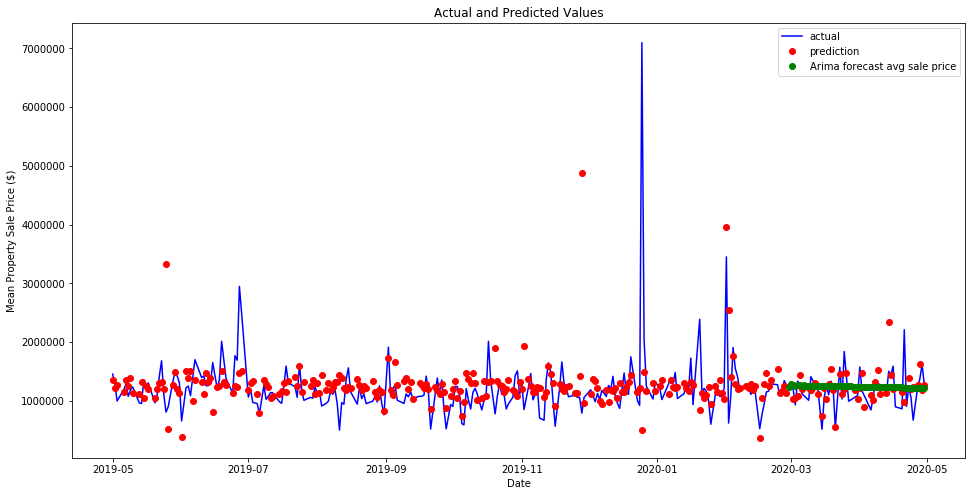

In [56]:

y_ols_preds_train = lr2.predict(x_train)
y_ols_preds_test = lr2.predict(x_test)
y_ols_preds_covid19 = lr2.predict(x_covid19)
date_data = df1.groupby('Date').mean().reset_index()
all_data_date = df1.groupby('Date').mean().reset_index()
train_prediction = pd.DataFrame(y_ols_preds_train)
test_prediction = pd.DataFrame(y_ols_preds_test)
covid19_prediction = pd.DataFrame(y_ols_preds_covid19)
prediction = pd.concat([train_prediction,test_prediction,covid19_prediction])
prediction.columns=['OLS_pred']
date = data_linear['Date']
prediction.set_index(date,inplace=True)
prediction = prediction.reset_index()
pred_date = prediction.groupby('Date').mean().reset_index()
# real covid 19 data

c19_date = c19[['Date','sale_price']].groupby('Date').mean().reset_index()
pred_c19 = pd.DataFrame(y_preds_covid19_all)
date = c19['Date']
pred_c19.columns=['OLS_pred']
pred_c19.set_index(date,inplace=True)
pred_c19=pred_c19.groupby('Date').mean()
pred_c19.reset_index(inplace=True)
# Plot the actual values(yes)
plt.figure(figsize=(16,8))
plt.plot(summary_date['date'], summary_date['sale_avg'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(pred_date['Date'],pred_date['OLS_pred'], 'ro', label = 'prediction')
# plot time-series covid-19 data
plt.plot(c19_date['Date'], train_forecast[0], 'go', label = 'Arima forecast avg sale price')
#plot the real covid19 pred data
#plt.plot(pred_c19['Date'],pred_c19['OLS_pred'], 'y.', label = 'all covid19 prediction')
#plt.xticks(rotation = 60)


#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Mean Property Sale Price ($)'); plt.title('Actual and Predicted Values')
plt.show()

The average property sales price analysis:
1. The property averge sales price didn't drop after the pandemic but the sold property number a day dropped significantly.
2. The pandemic does not affect the relationship between property features and its price.
3. The ARIME times series forecasting result furthur prove that the coronavirus doesn't affect the sales price.

# Ridge

31


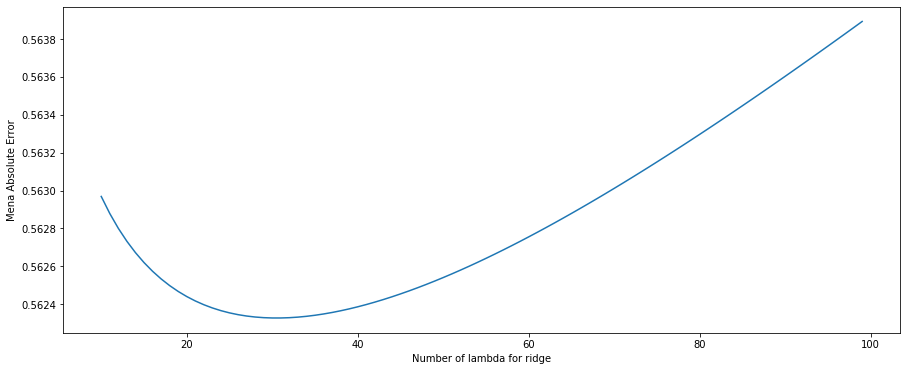

In [57]:

alpha = [x for x in range(10,100)]
cv_scores = []
for k in alpha:
    ridge = Ridge(alpha= k)
    scores = cross_val_score(ridge, x_train, y_train_log, cv=10)
    cv_scores.append(scores.mean())
MSE = [1-x for x in cv_scores]
optimal_alpha_index = MSE.index(min(MSE))
optimal_alpha = alpha[optimal_alpha_index]
print(optimal_alpha) # print the best k 
plt.figure(figsize=(15,6)) # plot MSE vs k
plt.plot(alpha, MSE)
plt.xlabel('Number of lambda for ridge')
plt.ylabel('Mena Absolute Error')
plt.show()

In [58]:
ridge = Ridge(alpha= 31) ##alpha value is very small that means the linear regression model doesn't overfit a lot
ridge.fit(x_train, y_train_log)
y_preds_train = ridge.predict(x_train)
y_preds_test = ridge.predict(x_test)
y_preds_covid19 = ridge.predict(x_covid19)
evaluation(ridge)

R-squared of the model on the training set is: 0.599983609782416
-----Test set statistics-----
R-squared of the model on the test set is: 0.5851026830986557
Mean absolute error of the prediction is: 0.26810021025081565
Mean squared error of the prediction is: 0.14188401364434505
Root mean squared error of the prediction is: 0.3766749442746956
Mean absolute percentage error of the prediction is: 1.9196790699606687
-----covid 19 set statistics-----
R-squared of the model on the test set is: 0.6460102854186442
Mean absolute error of the prediction is: 0.24616381767819043
Mean squared error of the prediction is: 0.1192393912022812
Root mean squared error of the prediction is: 0.3453105720974688
Mean absolute percentage error of the prediction is: 1.7569914585815491


# ElasticNet

0


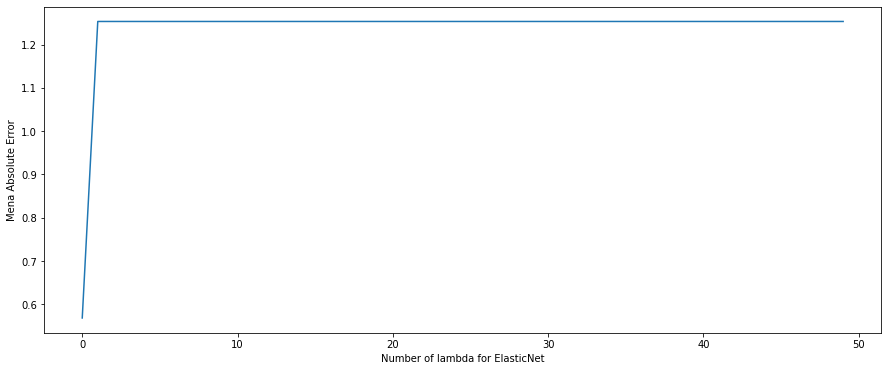

In [59]:

alpha = [x for x in range(0,50)]
# empty list that will hold cv scores
cv_scores = []
for k in alpha:
    ridge = ElasticNet(alpha= k)
    scores = cross_val_score(ridge, x_train, y_train_log, cv=10)
    cv_scores.append(scores.mean())
#graphical view
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_alpha_index = MSE.index(min(MSE))
optimal_alpha = alpha[optimal_alpha_index]
print(optimal_alpha)
# plot misclassification error vs k
plt.figure(figsize=(15,6))
plt.plot(alpha, MSE)
plt.xlabel('Number of lambda for ElasticNet')
plt.ylabel('Mena Absolute Error')
plt.show()

In [60]:
elasticregr = ElasticNet(alpha=0, l1_ratio=0.5) 
elasticregr.fit(x_train, y_train_log)
y_preds_train = elasticregr.predict(x_train)
y_preds_test = elasticregr.predict(x_test)
y_preds_covid19 = elasticregr.predict(x_covid19)
evaluation(elasticregr)

R-squared of the model on the training set is: 0.602473050093691
-----Test set statistics-----
R-squared of the model on the test set is: 0.5798478569605912
Mean absolute error of the prediction is: 0.26903298663852926
Mean squared error of the prediction is: 0.14368102652705095
Root mean squared error of the prediction is: 0.37905280176652295
Mean absolute percentage error of the prediction is: 1.9254208914253075
-----covid 19 set statistics-----
R-squared of the model on the test set is: 0.6483635982130395
Mean absolute error of the prediction is: 0.24526711059652265
Mean squared error of the prediction is: 0.11844669137696544
Root mean squared error of the prediction is: 0.34416085102313054
Mean absolute percentage error of the prediction is: 1.7511136905797438


# Lasso

0.0


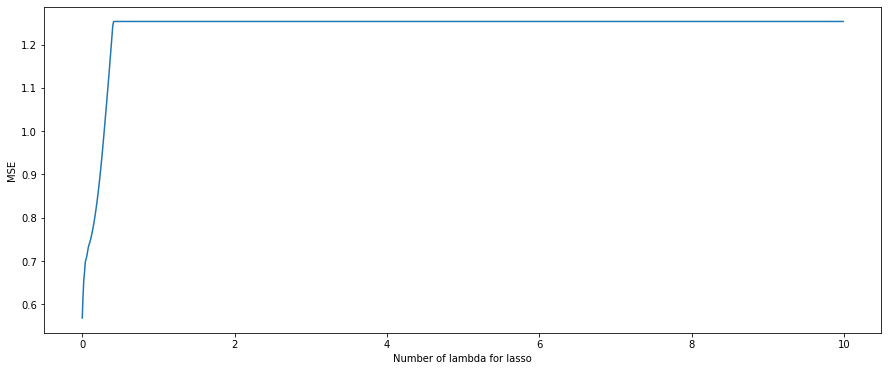

In [61]:
#hyper parameter tuning.Selecting best K
alpha = [x for x in np.arange(0,10,0.01)]
# empty list that will hold cv scores
cv_scores = []
for k in alpha:
    lasso = Lasso(alpha= k)
    scores = cross_val_score(lasso, x_train, y_train_log, cv=10)
    cv_scores.append(scores.mean())
#graphical view
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_alpha_index = MSE.index(min(MSE))
optimal_alpha = alpha[optimal_alpha_index]
print(optimal_alpha)
# plot misclassification error vs k
plt.figure(figsize=(15,6))
plt.plot(alpha, MSE)
plt.xlabel('Number of lambda for lasso')
plt.ylabel('MSE')
plt.show()

In [62]:
lasso = Lasso(alpha= 0) ##alpha value is very small that means the linear regression model doesn't overfit a lot
lasso.fit(x_train, y_train_log)
y_preds_train = lasso.predict(x_train)
y_preds_test = lasso.predict(x_test)
y_preds_covid19 = lasso.predict(x_covid19)
evaluation(lasso)

R-squared of the model on the training set is: 0.602473050093691
-----Test set statistics-----
R-squared of the model on the test set is: 0.5798478569605912
Mean absolute error of the prediction is: 0.26903298663852926
Mean squared error of the prediction is: 0.14368102652705095
Root mean squared error of the prediction is: 0.37905280176652295
Mean absolute percentage error of the prediction is: 1.9254208914253075
-----covid 19 set statistics-----
R-squared of the model on the test set is: 0.6483635982130395
Mean absolute error of the prediction is: 0.24526711059652265
Mean squared error of the prediction is: 0.11844669137696544
Root mean squared error of the prediction is: 0.34416085102313054
Mean absolute percentage error of the prediction is: 1.7511136905797438


In [63]:
coef = pd.Series(lasso.coef_,index=x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 45 variables and eliminated the other 28 variables


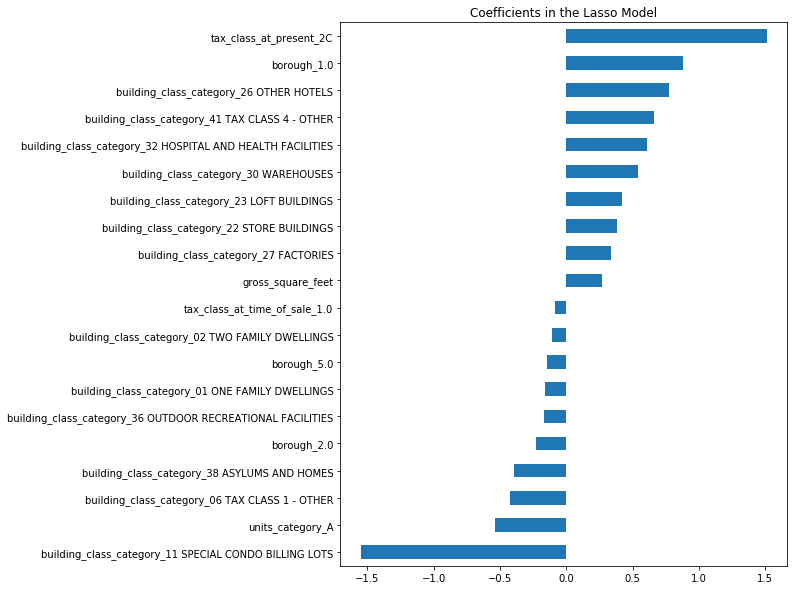

In [64]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# Random Forest

In [65]:
data_tree = df1.copy()
dataset_covid19 = data_tree[data_tree['Date']>='2020-02-29']
dataset_train = data_tree[data_tree['Date']<'2020-01-01']
dataset_test = data_tree[(data_tree['Date']>='2020-01-01')& (data_tree['Date']<'2020-02-29')]
x_train = dataset_train[num_features+list(one_hot_encoded.columns)]
y_train = dataset_train['sale_price']
x_test = dataset_test[num_features+list(one_hot_encoded.columns)]
y_test = dataset_test['sale_price']
x_covid19 = dataset_covid19[num_features+list(one_hot_encoded.columns)]
y_covid19 = dataset_covid19['sale_price']

In [66]:
rfc = ensemble.RandomForestClassifier(n_estimators = 20, random_state = 42, n_jobs=1)
rfc.fit(x_train,y_train)
y_preds_train = rfc.predict(x_train)
y_preds_test = rfc.predict(x_test)
y_preds_covid19 = rfc.predict(x_covid19)

print("R-squared of the model on the training set is: {}".format(rfc.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfc.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("-----covid 19 set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfc.score(x_covid19, y_covid19)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_covid19, y_preds_covid19)))
print("Mean squared error of the prediction is: {}".format(mse(y_covid19, y_preds_covid19)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_covid19, y_preds_covid19)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_covid19 - y_preds_covid19) / y_covid19)) * 100))


R-squared of the model on the training set is: 0.9494841693347563
-----Test set statistics-----
R-squared of the model on the test set is: 0.011893870082342177
Mean absolute error of the prediction is: 502795.95760902716
Mean squared error of the prediction is: 1357786064849.2537
Root mean squared error of the prediction is: 1165240.7754834422
Mean absolute percentage error of the prediction is: 35.891580185597014
-----covid 19 set statistics-----
R-squared of the model on the test set is: 0.008028098344204716
Mean absolute error of the prediction is: 479750.61665830406
Mean squared error of the prediction is: 1277989933935.4246
Root mean squared error of the prediction is: 1130482.168782606
Mean absolute percentage error of the prediction is: 32.14707700336596


In [67]:
base_imp = imp_df(x_train.columns, rfc.feature_importances_)
base_imp[0:5]

,feature,feature_importance
0,gross_square_feet,0.423992
1,land_square_feet,0.341079
2,year_built,0.200349
3,borough_4.0,0.003341
4,borough_2.0,0.003074


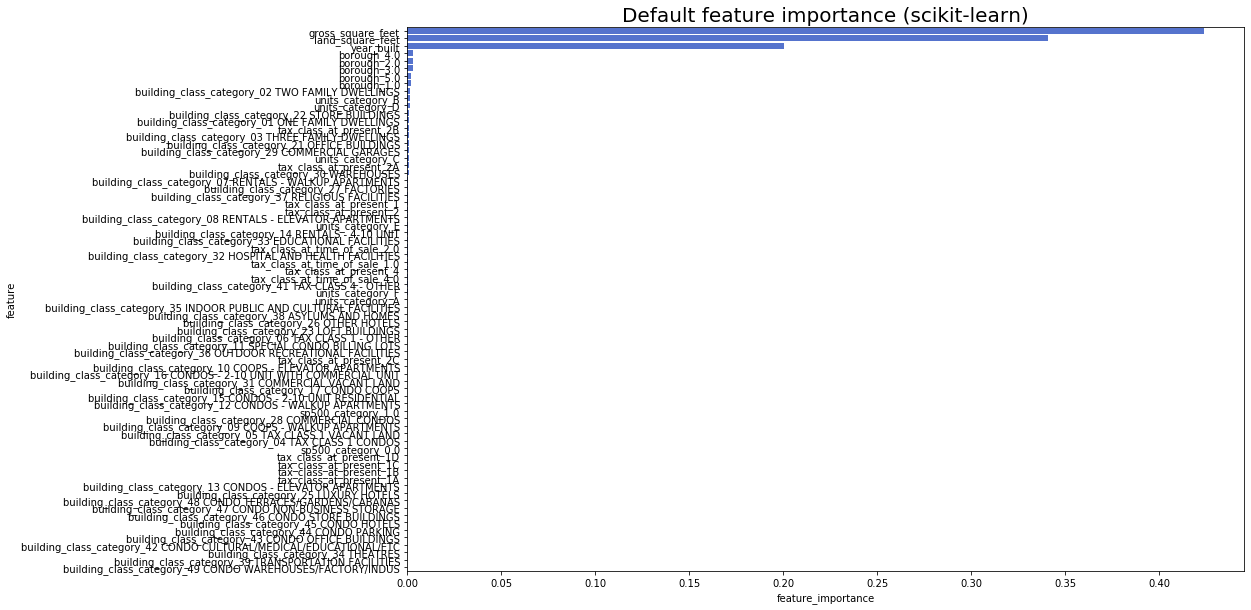

In [68]:
plt.figure(figsize=(15,10))
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

It seems that the top 3 most important features are: <br>
• gross_square_feet<br>
• land_square_feet<br>
• year_built<br>
Other features don't have any impact on target property sales price, which is kind of werid because we know if the house is in manhattan or not plays a big role on the price. Let's see how it is evaluated by different approaches.

In [69]:
def r2(rfc, x_train, y_train):
    return r2_score(y_train, rfc.predict(x_train))

perm_imp_rfpimp = permutation_importances(rfc, x_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

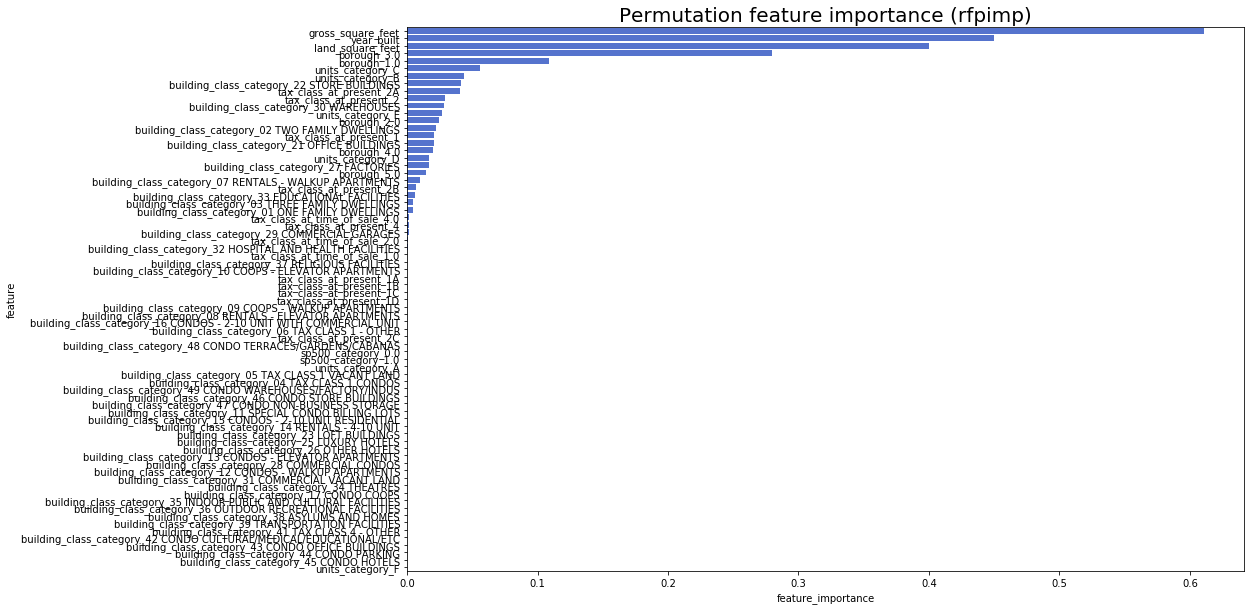

In [70]:
plt.figure(figsize=(15,10))
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

# Conclusion

• Coronavirus does not affect the property sales price in NYC nor the property sales price prediction model(linear regression)/ time series model(Arima)<br>
• Inference purpose: Square feet, year-built, location(Manhattan or Brooklyn), building class category


# Improvement

• Try different hyperparameters and try more complicated algorithms to improve performance <br>
• Try to include more features that could possibly affect the property sales price(e.g. DOM, Interest rate…)<br>
•  Check Gauss Markov Conditions and deal with multicollinearity<br>
• Categorize property type and built models in different type property<br>
